In [13]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import subprocess

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC  

import joblib

from openai import OpenAI
import requests
import os
from dotenv import load_dotenv

In [14]:
print('hello')

hello


In [15]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
true_df=pd.read_csv('True.csv')
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [17]:
fake_df=pd.read_csv('Fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [18]:
true_df['label'] = 0  # real news
fake_df['label'] = 1 # fake news

In [19]:
df = pd.concat([true_df, fake_df], ignore_index=True)#ignore index to avoid duplicate indexes
df = df.sample(frac=1, random_state=42).reset_index(drop=True) #randomizing the rows and setting the random seed so we get same shuffle all the time.


In [9]:
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [20]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [21]:
for col in ['text', 'title', 'subject']:
    df[col] = df[col].apply(clean_text)


In [ ]:
# Add article length column
text_length = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True, palette='Set2')
plt.title("Distribution of Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [22]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=7000,
    min_df=5,
    max_df=0.7,
    sublinear_tf=True
)

# Split the dataset using the cleaned 'text' column
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'], 
    test_size=0.2, 
    random_state=42
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Training matrix shape:", X_train_tfidf.shape)
print("Test matrix shape:", X_test_tfidf.shape)

Training matrix shape: (35918, 7000)
Test matrix shape: (8980, 7000)


In [42]:
logmodel=LogisticRegression()
logmodel.fit(X_train_tfidf, y_train)
y_pred = logmodel.predict(X_test_tfidf)


In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9908685968819599
Precision: 0.993756727664155
Recall: 0.988648532876419
F1 Score: 0.9911960489585571

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4311
           1       0.99      0.99      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



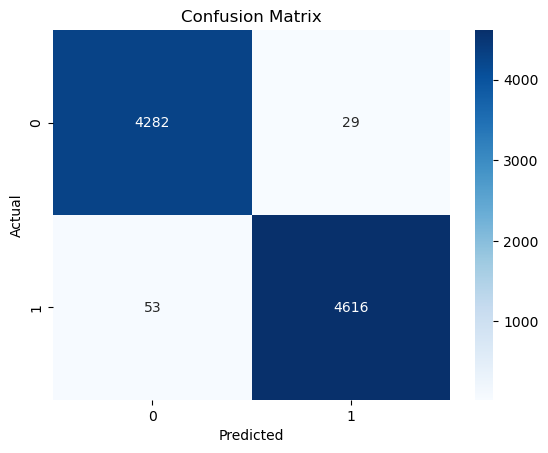

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

AUC Score: 0.9992081203657043


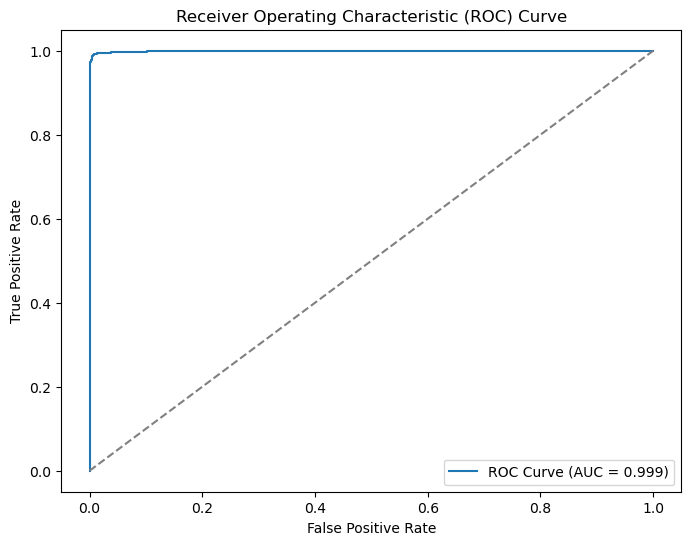

In [45]:
y_pred_proba = logmodel.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [46]:
print(y_train.value_counts(normalize=True))  # Shows proportion of each class
print(y_train.value_counts())  

label
1    0.523749
0    0.476251
Name: proportion, dtype: float64
label
1    18812
0    17106
Name: count, dtype: int64


In [47]:
# Initialize Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=42)

# Train
dtree.fit(X_train_tfidf, y_train)
y_dpred = dtree.predict(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_dpred))
print("\nClassification Report:\n", classification_report(y_test, y_dpred))

Accuracy: 0.9962138084632517

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4311
           1       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



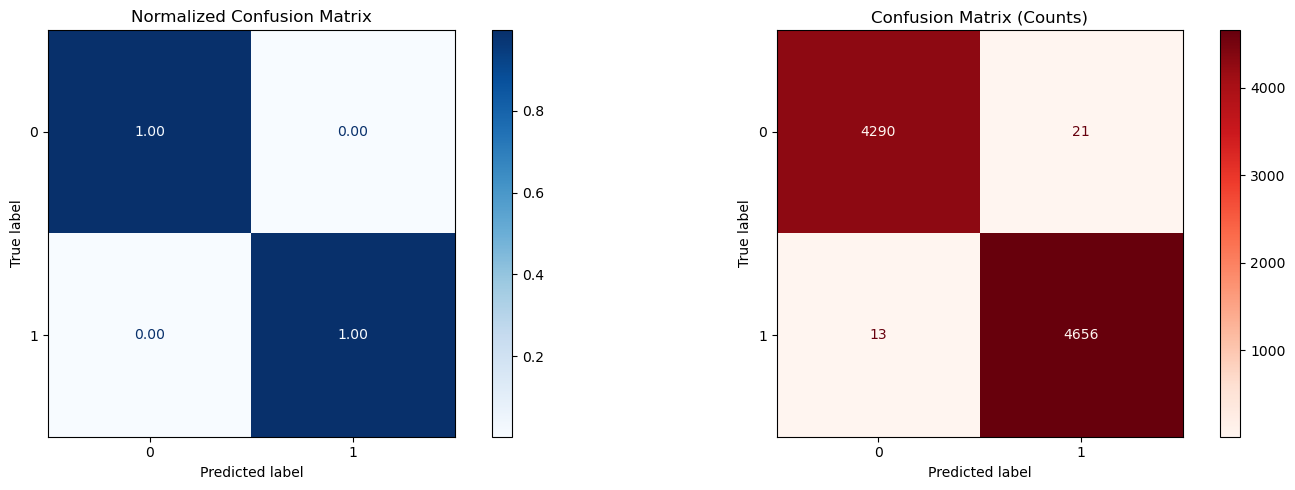

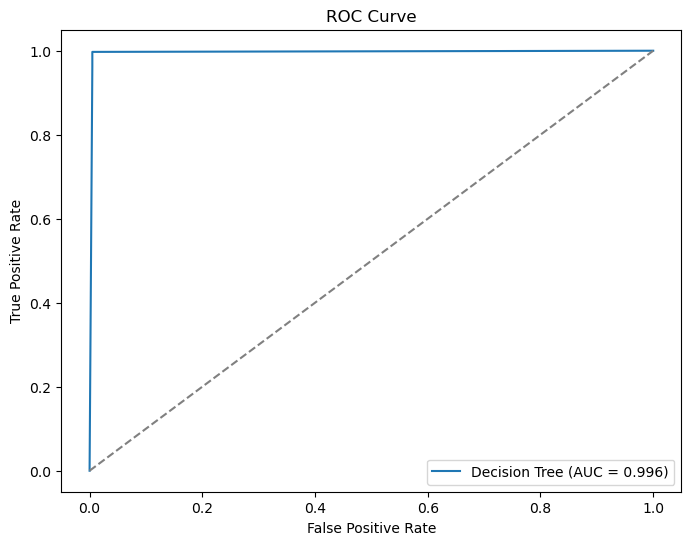

AUC Score: 0.9961


In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_test, y_dpred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=dtree.classes_)
disp.plot(cmap='Blues', ax=ax1, values_format='.2f')
ax1.set_title("Normalized Confusion Matrix")

# Plot regular confusion matrix
cm_counts = confusion_matrix(y_test, y_dpred)
disp_counts = ConfusionMatrixDisplay(cm_counts, display_labels=dtree.classes_)
disp_counts.plot(cmap='Reds', ax=ax2, values_format='d')
ax2.set_title("Confusion Matrix (Counts)")

plt.tight_layout()
plt.show()

# ROC Curve and AUC
y_dprob = dtree.predict_proba(X_test_tfidf)[:, 1]  # Probability estimates for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_dprob)
auc_score = roc_auc_score(y_test, y_dprob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC Score: {auc_score:.4f}")

In [49]:
gbc = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)

# Train
gbc.fit(X_train_tfidf, y_train)

# Predict
y_gpred = gbc.predict(X_test_tfidf)

# Evaluate
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_gpred))
print("\nClassification Report:\n", classification_report(y_test, y_gpred))


Gradient Boosting Accuracy: 0.9947661469933184

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4311
           1       1.00      0.99      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



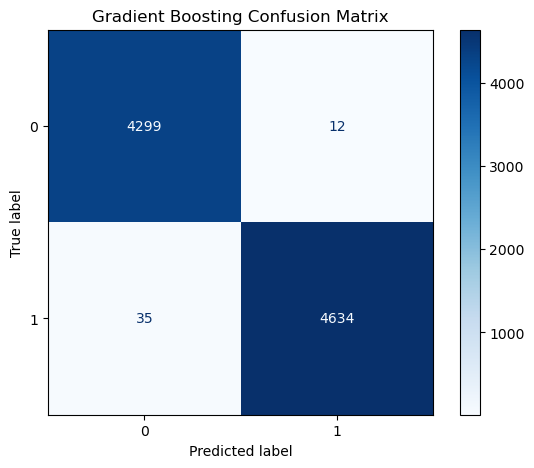

In [53]:
fig, ax = plt.subplots(figsize=(7,5))

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_gpred)
disp = ConfusionMatrixDisplay(cm, display_labels=gbc.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title("Gradient Boosting Confusion Matrix")
plt.show()

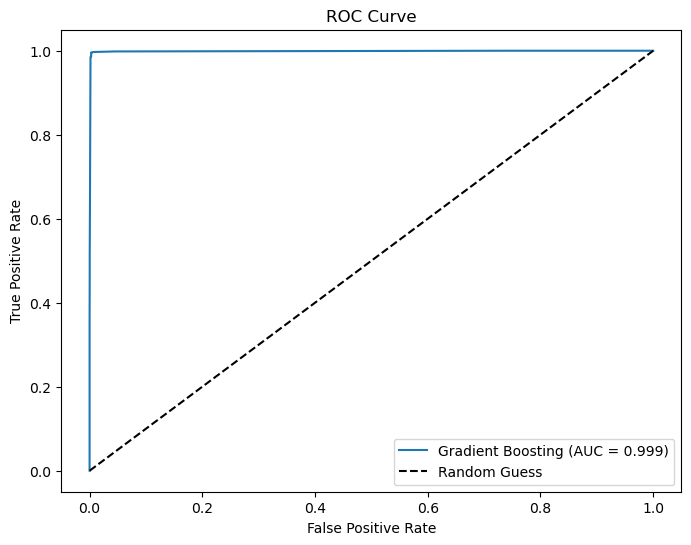

AUC Score: 0.9988


In [54]:
y_gprob = gbc.predict_proba(X_test_tfidf)[:, 1]  # Class 1 probabilities[1][6]

# Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_gprob)
auc_score = roc_auc_score(y_test, y_gprob)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.4f}")

In [55]:
nb = MultinomialNB()

# Train
nb.fit(X_train_tfidf, y_train)

# Predict
y_nbpred = nb.predict(X_test_tfidf)

# Evaluate
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_nbpred))
print("\nClassification Report:\n", classification_report(y_test, y_nbpred))

Naive Bayes Accuracy: 0.9497772828507796

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4311
           1       0.95      0.95      0.95      4669

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [56]:
joblib.dump(nb, 'naivebayes.joblib')
print("Model saved successfully.")

Model saved successfully.


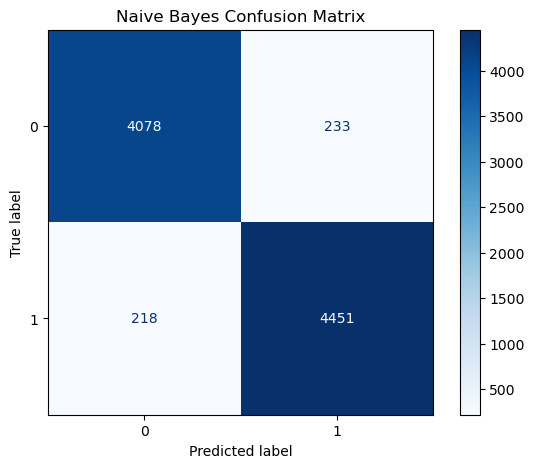

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_nbpred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7,5))
disp = ConfusionMatrixDisplay(cm, display_labels=nb.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title("Naive Bayes Confusion Matrix")
plt.show()


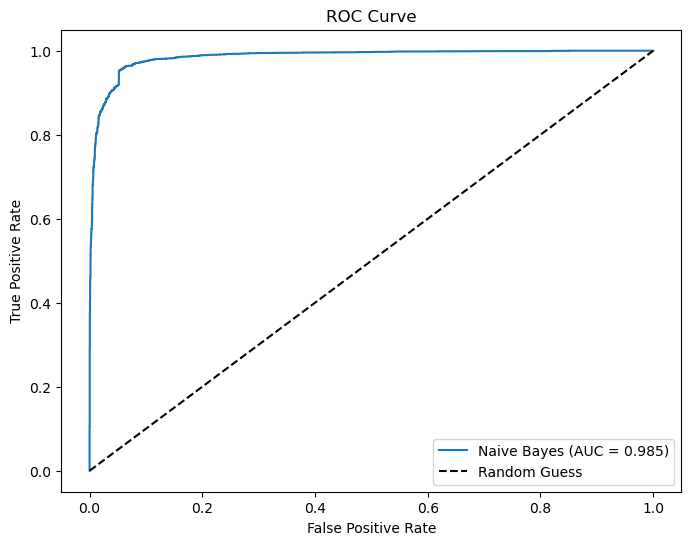

AUC Score: 0.9855


In [58]:
y_nbprob = nb.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_nbprob)
auc_score = roc_auc_score(y_test, y_nbprob)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.4f}")

In [23]:
svm = LinearSVC( random_state=42, max_iter=2000, class_weight='balanced')

# Train
svm.fit(X_train_tfidf, y_train)

# Predict
y_svcpred = svm.predict(X_test_tfidf)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_svcpred))
print("\nClassification Report:\n", classification_report(y_test, y_svcpred))

SVM Accuracy: 0.9971046770601336

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4311
           1       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



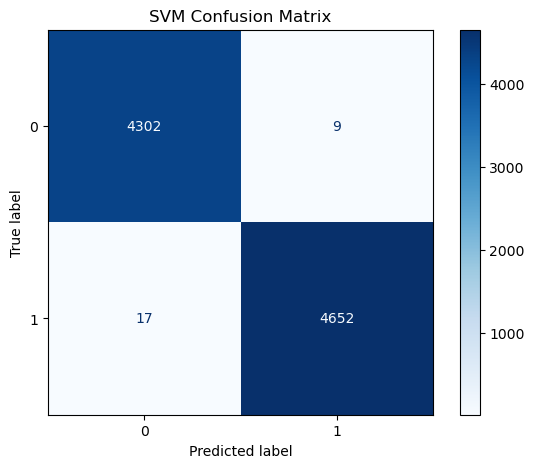

In [24]:
cm = confusion_matrix(y_test, y_svcpred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7,5))
disp = ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title("SVM Confusion Matrix")
plt.show()

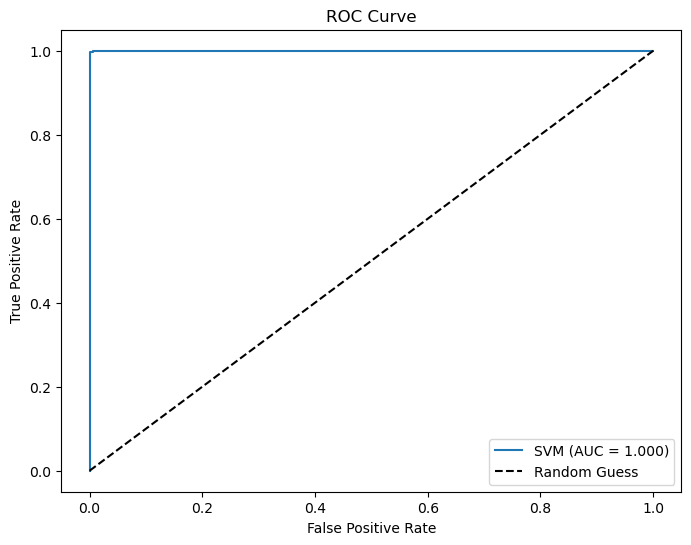

AUC Score: 0.9999


In [25]:
y_scores = svm.decision_function(X_test_tfidf)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'AUC Score: {auc_score:.4f}')

In [26]:
from backendd import TextCleaner  # Import from backendd.py

# Define and train your pipeline
pipeline = Pipeline([
    ('cleaner', TextCleaner()),  # Uses TextCleaner from backendd.py
    ('tfidf', TfidfVectorizer(max_features=7000, ngram_range=(1,2))),
    ('Lsvm', LinearSVC(max_iter=1000))
])

pipeline.fit(X_train, y_train)  # Use your training data

# Save the pipeline
joblib.dump(pipeline, 'pipeline_with_linearSVC.joblib')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['pipeline_with_linearSVC.joblib']